# SCC0270 - Redes Neurais e Aprendizado Profundo
---

Alunos:
- 10716504 - Helbert Moreira Pinto
- 10377708 - João Marcos Della Torre Divino

---

Exercício 2 - Implemente uma rede MLP usando apenas pacotes básicos do Python, como a biblioteca Numpy.

---

### Introdução

No exercÍcio anterior, foi implementado o _perceptron_, o qual consegue encontrar um plano separador entre dois conjuntos, desde que os elementos deles sejam linearmente separáveis. Por exemplo, vê-se abaixo duas associações de conjuntos: na primeira tem-se conjuntos linearmente separáveis (existe um hiperplano separador entre eles); e na segunda não se tem um hiperplano que os separe.

<img src='imgs/separaveis.png' alt='Linearmente separável' width='1000'/>

Como a maioria dos problemas reais exigem soluções não linearmente separáveis, há uma limitação considerável no uso do _perceptron_.  
Como exemplo pode-se citar o problema do XOR (Exclusive OR), que possui a seguinte tabela verdade:

| A | B | S |
|:-:|:-:|:-:|
| 0 | 0 | 1 |
| 0 | 1 | 0 |
| 1 | 0 | 0 |
| 1 | 1 | 1 |

Para uma melhor comparação, a figura abaixo mostra graficamente lado a lado como são os casos do AND, do OR e do XOR:

<img src='imgs/xor2.png' alt='Linearmente separável' width='500'/>

Ora, nota-se que no caso do XOR não há uma solução linear que consiga separar as duas classes.

Para solucionar isso, foi proposta a construção de uma rede de _perceptrons_, na qual a saída dos neurônios da camada atual alimenta os de camadas posteriores. Tal configuração é conhecida por MLP (MultiLayer Perceptron).

A cada camada de processamento da rede é adicionado um novo plano separador dos conjuntos, resolvendo assim problemas que não são linearmente separáveis.

<img src='imgs/mlp.png' alt='Linearmente separável' width='500'/>

---
### Implementação da rede

A implementação da etapa de propagação para a saída é dado pelo seguinte trecho do código:  
```python
def feedforward(u, fa=sigmoide):
    # array A armazena os valores das saidas das camadas
    A = [np.array(u)]
    for peso, bias in zip(pesos, bias):
        u = fa(np.dot(u, peso) + bias)
        A.append(u)
    return u, A
```
Nota-se que a função de ativação foi definida de maneira a ser parametrizável, para ser possível utilizar outra que não a sigmoide, como por exemplo a função de tangente hiperbólica, caso houvesse valores negativos no conjunto de dados.

Contudo, diferentemente do _perceptron_ simples, no qual o erro da saída estava diretamente relacionado aos pesos do próprio neurônio, numa MLP o erro da saída é indiretamente influenciado por uma pequena parcela de todos os neurônios que compõe a rede. Deste modo, o ajuste dos pesos deve ser feito da camada de saída (onde o erro pode ser mensurado) para as camadas anteriores. O nome deste processo de retropropagação do erro é conhecida por _backpropagation_.

O algoritmo de _backpropagation_ é baseado na ideia de ajustes dos pesos na direção de minimização da função de custo, que neste caso é a (saida esperada - saida observada).  
```python
def diferenca_vetorial(a, b):
    return a - b
```

Para encontrar a direção de minimização da função de custo, usa-se o gradiente descendente, como pode ser visto na figura abaixo.

<img src='imgs/gradiente.png' alt='Linearmente separável' width='500'/>

Para a implementação, foi utilizada a regra delta para calcular os gradientes dos pesos:

$\delta_0 = erro \cdot \frac {d} {dx} fa(A_n)$

$\delta_i = \delta_{i-1} \cdot W^{T}_{i} \cdot \frac {d} {dx} fa(A_{i}), i = 1, 2, 3, ... , n-1$

em que:

$fa$ = função de ativação (sigmoide)

$W_i$ = pesos da camada i

$A_i$ = vetor de saída da camada i 

Após os calculos dos deltas, os gradientes podem ser calculados por:

$\nabla W_i = \delta_{n-i} \cdot A_i, i = 0,1,2,...,n$

A implementação de retropropagação dos erros ficou então do seguinte modo:
```python
def backpropagation(amostra, taxa, fa=sigmoide, dfa=dsigmoide, funcao_custo=diferenca_vetorial):
    x, y = amostra
    saida, a = feedforward(x, fa)
    erro = funcao_custo(y, saida)

    # ajustar pesos e bias
    # calcular os deltas da camada de saida para a camada de entrada
    delta = [erro * dfa(saida)]
    for i in range(len(a)-1, 0, -1):
        delta_i = delta[len(delta)-1].dot(pesos[i-1].T) * dfa(a[i-1])
        delta.append(delta_i)
    # revertendo os deltas
    delta = delta[::-1][1:]

    # calculando os gradientes e aplicando alterações nos pesos
    # w = w + (taxa * (entrada . delta))
    for i, w in enumerate(pesos):
    # bug da unidimensionalidade -> a[i].T
        if len(a[i].shape) == 1:
            a[i] = a[i].reshape(1, len(a[i]))
        w += (taxa * np.dot(a[i].T, delta[i]))

    # aplicando alterações nos bias
    # b = b + (taxa * (1 . delta))
    for i, b in enumerate(bias):
        b += (taxa * delta[i])
    return
```

Para treinar a rede, foi utilizado o algoritmo mostrado na imagem abaixo, na seguinte ordem:
1. apresentar uma amostra
2. calcular o erro observado
3. calcular os deltas e gradientes
4. ajustar os pesos e os bias 
5. apresentar nova amostra e voltar ao passo 1

<img src='imgs/treino-mlp.png' alt='Linearmente separável' width='500'/>

A implementação da etapa de treino é dada pelo seguinte código:
```python
def treino(amostras, lim_erro=1e-3, taxa=0.5, funcao_custo=diferenca_vetorial):
    epoca = 0
    erro_epoca = []

    while True:
        erro_epoca = []

        for amostra in amostras:
            x, y = amostra
            saida, _ = feedforward(x)
            erro_epoca.append(funcao_custo(y, saida))
            backpropagation(amostra, taxa=taxa)
        
        # erro quadratico medio
        mse = np.sum(np.square(erro_epoca)) / len(erro_epoca)
        erro_epoca.append(mse)
        
        # a cada 5k epocas exibe o erro quadratico medio da epoca
        if epoca % 5000 == 0:
            print('Epoca: {:06d} | MSE: {:.8f}'.format(epoca, mse))
        
        # condição de parada: erro quadratico medio menor que um limite pre-estabelecido
        if mse < lim_erro:
            break
        
        epoca += 1
    
    return erro_epoca
```  

---
### Apresentando o problema do XOR para a rede

Inicialmente, foram utilizados os dados do XOR como entrada, para ver se a rede estava conseguindo ajustar os pesos adequadamente.

In [1]:
from src.mlp import MLP
rede_xor = MLP([2,4,1], seed=123)

xor = [
    ([0,0], [1]), 
    ([0,1], [0]), 
    ([1,0], [0]), 
    ([1,1], [1]), 
]

Antes de treinar a rede, nota-se que as saídas possuem valores aleatórios.

In [2]:
for x, _ in xor:
    y, _ = rede_xor.feedforward(x)
    print(f'{x} => {y}')

[0, 0] => [[0.93322454]]
[0, 1] => [[0.9175108]]
[1, 0] => [[0.89390771]]
[1, 1] => [[0.87701227]]


Na etapa de treinamento, com o decorrer das iterações, pode-se notar a minimização da função de custo.

Epoca: 00000 | MSE: 0.82727145
Epoca: 01105 | MSE: 0.00998878


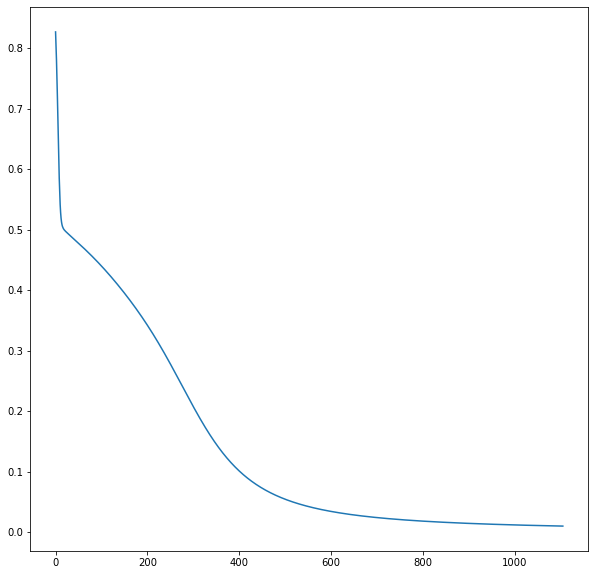

In [3]:
erro_epoca = rede_xor.treino(amostras=xor, taxa=0.5, lim_erro=1e-2)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

Por fim, tem-se que os pesos foram ajustados corretamente ao ver as saídas para cada entrada do XOR.

In [4]:
for x, _ in xor:
    y, _ = rede_xor.feedforward(x)
    print(f'{x} => {y}')

[0, 0] => [[0.94666088]]
[0, 1] => [[0.06856388]]
[1, 0] => [[0.06512135]]
[1, 1] => [[0.91038486]]


---
### Problema do auto-associador

Como proposta do exercício, solicitava-se também a utilização de uma MLP para construir um auto-associador, no qual a saída da rede é igual a entrada. Através de tal configuração, busca-se fazer o mapeamento das caracteristicas da entrada, utilizando uma camada intermediária com poucos neurônios (aqui, $(\log_2N)$ neurônios, sendo $N$ o tamanho da entrada).

<img src='imgs/encoder.png' alt='Linearmente separável' width='500'/>

Desta forma, foram avaliados dois casos de entrada:
- $Id_8$: Identidade de ordem 8 ou Id(8x8)
- $Id_{16}$: Identidade de ordem 16 ou Id(16x16)

#### Identidade 8

Inicialmente, foram apresentadas à rede as amostras de entrada. Como pode ser visto, uma vez que nenhum treinamento foi feito, a saída difere totalmente da entrada.

In [5]:
import numpy as np
from src.mlp import MLP
rede_id8 = MLP([8,3,8], seed=123)

Id8 = [(z,z) for z in np.identity(8)]

for x, _ in Id8:
    y, _ = rede_id8.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0.] => [[0.03 0.58 0.6  0.34 0.75 0.76 0.81 0.64]]
[0. 1. 0. 0. 0. 0. 0. 0.] => [[0.03 0.48 0.52 0.42 0.77 0.76 0.91 0.72]]
[0. 0. 1. 0. 0. 0. 0. 0.] => [[0.04 0.54 0.49 0.47 0.77 0.79 0.89 0.8 ]]
[0. 0. 0. 1. 0. 0. 0. 0.] => [[0.03 0.62 0.59 0.32 0.74 0.73 0.8  0.58]]
[0. 0. 0. 0. 1. 0. 0. 0.] => [[0.02 0.58 0.68 0.21 0.73 0.66 0.76 0.31]]
[0. 0. 0. 0. 0. 1. 0. 0.] => [[0.02 0.36 0.6  0.35 0.77 0.73 0.92 0.57]]
[0. 0. 0. 0. 0. 0. 1. 0.] => [[0.02 0.48 0.67 0.24 0.75 0.68 0.83 0.37]]
[0. 0. 0. 0. 0. 0. 0. 1.] => [[0.02 0.45 0.64 0.24 0.75 0.65 0.88 0.34]]


Treinamento da rede:

Epoca: 00000 | MSE: 9.78916096
Epoca: 05000 | MSE: 0.02637493
Epoca: 10000 | MSE: 0.01098091
Epoca: 10828 | MSE: 0.00999956


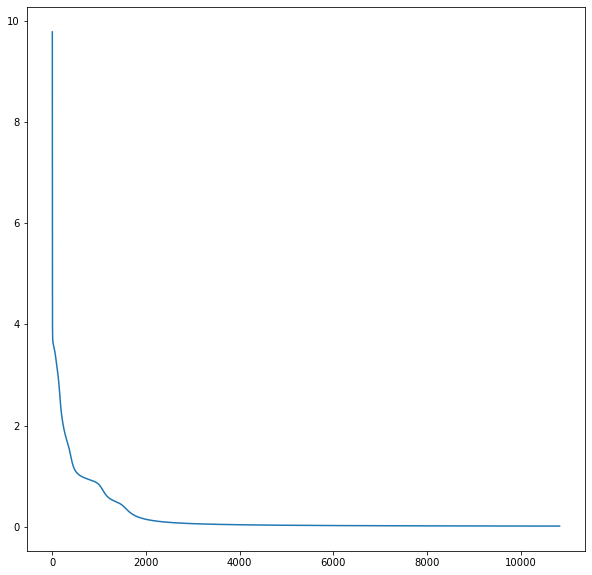

In [6]:
erro_epoca = rede_id8.treino(amostras=Id8, taxa=0.5, lim_erro=1e-2)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

Teste da rede:

In [7]:
for x, _ in Id8:
    y, _ = rede_id8.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0.] => [[0.97 0.   0.03 0.02 0.   0.   0.   0.  ]]
[0. 1. 0. 0. 0. 0. 0. 0.] => [[0.   0.97 0.   0.03 0.02 0.   0.   0.01]]
[0. 0. 1. 0. 0. 0. 0. 0.] => [[0.02 0.   0.96 0.   0.   0.02 0.   0.  ]]
[0. 0. 0. 1. 0. 0. 0. 0.] => [[0.03 0.02 0.   0.95 0.   0.03 0.   0.01]]
[0. 0. 0. 0. 1. 0. 0. 0.] => [[0.   0.02 0.01 0.   0.97 0.   0.02 0.  ]]
[0. 0. 0. 0. 0. 1. 0. 0.] => [[0.   0.   0.02 0.02 0.   0.97 0.   0.01]]
[0. 0. 0. 0. 0. 0. 1. 0.] => [[0.   0.   0.02 0.   0.01 0.   0.97 0.02]]
[0. 0. 0. 0. 0. 0. 0. 1.] => [[0.   0.01 0.   0.02 0.   0.02 0.02 0.98]]


#### Identidade 16

Analogamente ao caso anterior, num primeiro momento, a saída da rede é distinta da entrada já que a rede não foi treinada.

In [8]:
import numpy as np
from src.mlp import MLP
rede_id16 = MLP([16,4,16], seed=123)

Id16 = [(z,z) for z in np.identity(16)]

for x, _ in Id16:
    y, _ = rede_id16.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.52 0.44 0.88 0.65 0.26 0.63 0.83 0.34 0.7  0.45 0.78 0.35 0.68 0.48
  0.47 0.89]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.67 0.56 0.9  0.7  0.17 0.72 0.83 0.13 0.78 0.41 0.76 0.49 0.69 0.62
  0.49 0.84]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.59 0.69 0.8  0.57 0.14 0.8  0.91 0.2  0.62 0.29 0.44 0.7  0.67 0.4
  0.45 0.67]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.61 0.67 0.81 0.57 0.14 0.78 0.9  0.23 0.65 0.29 0.43 0.67 0.65 0.4
  0.43 0.67]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.7  0.5  0.94 0.66 0.11 0.5  0.91 0.18 0.87 0.28 0.59 0.39 0.75 0.44
  0.36 0.84]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.67 0.63 0.93 0.69 0.09 0.68 0.92 0.07 0.81 0.29 0.63 0.59 0.78 0.55
  0.48 0.81]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.36 0.45 0.8  0.57 0.31 0.66 0.88 0.55 0.5  0.45 0.72 0.39 0.69 0.32
  0.49 0.87]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0

Treinamento da rede:

Epoca: 00000 | MSE: 32.74778137
Epoca: 05000 | MSE: 0.06813614
Epoca: 10000 | MSE: 0.02899282
Epoca: 15000 | MSE: 0.01831458
Epoca: 20000 | MSE: 0.01335742
Epoca: 25000 | MSE: 0.01050163
Epoca: 26171 | MSE: 0.00999983


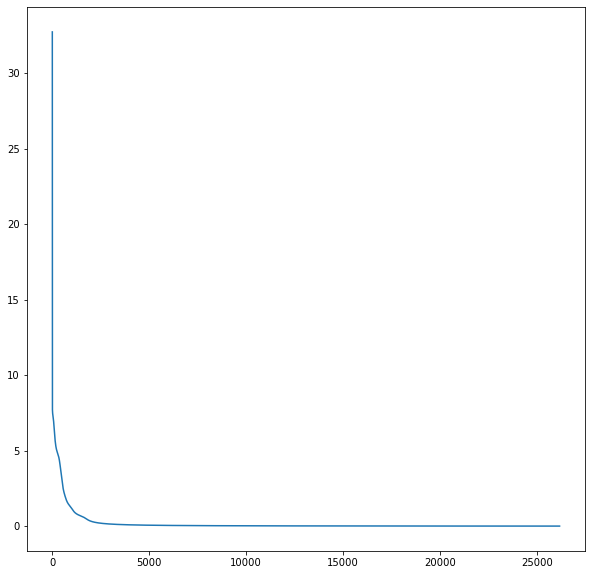

In [9]:
erro_epoca = rede_id16.treino(amostras=Id16, taxa=0.5, lim_erro=1e-2)

from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
plt.plot(erro_epoca)
plt.show()

Teste da rede:

In [10]:
for x, _ in Id16:
    y, _ = rede_id16.feedforward(x)
    print(f'{x} => {np.round(y,2)}')

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.97 0.01 0.   0.01 0.02 0.   0.   0.   0.01 0.   0.   0.   0.   0.
  0.   0.01]]
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.02 0.97 0.   0.01 0.   0.   0.   0.   0.   0.   0.   0.   0.01 0.01
  0.   0.01]]
[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.97 0.   0.   0.02 0.   0.   0.   0.   0.01 0.01 0.01 0.02
  0.   0.  ]]
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.02 0.01 0.   0.97 0.   0.01 0.   0.01 0.   0.   0.   0.   0.   0.
  0.   0.  ]]
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.01 0.   0.   0.   0.98 0.   0.   0.   0.   0.   0.   0.   0.   0.01
  0.   0.  ]]
[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.02 0.02 0.   0.97 0.   0.   0.   0.01 0.   0.01 0.   0.
  0.   0.  ]]
[0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] => [[0.   0.   0.   0.   0.   0.   0.98 0.01 0.01 0.   0.01 0.01 0.   0.
  0.01 0.  ]]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0